# Federated Learning
```
It's not a real Federated environment.  
We'll just see the summerizing method for the locals' weights

if you cannot access the data to train your model, to train the private data, you can transfer the model, instead of transfer of data. In the each local which have their own dataset, 
the locals take your model and train it with their dataset. 
 After a few epochs of training, the local models have trained in the different directions.
To update the global model, just gather all local model not the data, And make the averages of weights for the local models, then you will get the updated global model.
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from IPython.display import clear_output 

import os
import random
import matplotlib.pyplot as plt
import numpy as np

C:\Users\zhi12\.conda\envs\GCN_STUDY\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" device: {device}")

 device: cuda


### DATASET

In [3]:
def load_data(root, batch_size):
    mnist_train = torchvision.datasets.FashionMNIST(root=root,
                                                     transform=transforms.ToTensor(),
                                                     train=True,
                                                     download=True)

    mnist_test = torchvision.datasets.FashionMNIST(root=root,
                                                    transform=transforms.ToTensor(),
                                                    train=False,
                                                    download=True)
    
    data_loader = DataLoader(dataset=mnist_train,
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)

    return data_loader, mnist_train, mnist_test


### IID DATASET builder

In [4]:
def get_data_split(num_locals:int, dataset:object, IID=True, batch_size=50):
    # split data
    # num_local = the number of locals
    # dataset = the dataset you wanna split
    
    data_num_list = [60000 //num_locals] * num_locals        
    
    if IID:
        datasets = torch.utils.data.random_split(dataset, data_num_list)       
        data = []
        for i in range(num_locals):
            X = DataLoader(dataset=datasets[i],
                           batch_size=batch_size,
                           shuffle=True,
                           drop_last=False)
            data.append(X)
            
    else:  # NON-IID: Not Yet..
        pass        
    
    return data


## Define Model

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.ReLU())
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(256, 10, bias=True))

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        out = self.layer4(out)
        return out
    


# [1] Decentralized (federated learning)

In [6]:
# the number of locals
# the dataset and locals will be splited in this number.
num_locals = 100

# make global model and locals
global_model = CNN().to(device)
local_models = [CNN().to(device) for i in range(num_locals)]

# make datasets
root = "./DATA"
batch_size = 100
data_loader, mnist_train, mnist_test = load_data(root, batch_size)
local_train = get_data_split(num_locals=num_locals, dataset=mnist_train)

### Weight Load Method

In [7]:
# load from global model
def weight_load():
    for local_model in local_models:
        global_weight = global_model.state_dict()
        local_model.load_state_dict(global_weight)

### Update Method

In [8]:
from collections import OrderedDict
# update from global model
def weight_update(update_list:list):
    num = sum(update_list)
    avg_weights = OrderedDict()

    for local_model, update in zip(local_models, update_list):
        if update:
            local_weights = local_model.state_dict()
            for key in local_model.state_dict().keys():
                if avg_weights.get(key) == None:
                    avg_weights[key] = local_weights[key] / num
            
                else:
                    avg_weights[key] += local_weights[key] / num
                    
    global_model.load_state_dict(avg_weights)
            

###  Train Locals method

In [9]:
def train_locals(epoch=1):
    loss_function = nn.CrossEntropyLoss()
    
    for idx, [local_model, local_data] in enumerate(zip(local_models, local_train)):
        optimizer = optim.Adam(local_model.parameters())
        print(f"local: {idx+1:03}/{num_locals}", end="\r")
        local_model.train()

        for e in range(epoch): 
            for x, y in local_data:
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                y_predict = local_model(x)

                loss = loss_function(y_predict, y)
                loss.backward()
                optimizer.step()
    print(" "*50, end="\r")

### Check performance

In [10]:
def check_performance(model, test_data):
    model.eval()
    cnt = 0
    for x, y in test_data:
        x = x.to(device)
        y_predict = model(x.reshape(1, 1, 28, 28))
        y_predict = torch.argmax(y_predict)
        if y_predict == y:
            cnt += 1
    return cnt / len(test_data)

### Training

In [11]:
num_round = 10
acc_list = []
for i in range(num_round):
    print(f"round: {i+1}/{num_round}")
    
    # 1. load weights from the global to each local
    weight_load()
    
    # 2. train locals seperately
    train_locals(epoch=5)
    
    # 3. check 
    update_list = [1] * num_locals 
    
    # 4. update locals' weights to the global
    weight_update(update_list=update_list)
    
    # 5. check performance
    acc = check_performance(global_model, mnist_test)
    acc_list.append(acc)
    print(f'{acc:.2%}')
    
print("fin")

round: 1/10
72.38%                                            
round: 2/10
77.29%                                            
round: 3/10
79.77%                                            
round: 4/10
81.79%                                            
round: 5/10
83.32%                                            
round: 6/10
84.33%                                            
round: 7/10
85.02%                                            
round: 8/10
85.58%                                            
round: 9/10
86.05%                                            
round: 10/10
86.47%                                            
fin


# [2] Centralized training

In [12]:
central_model = CNN().to(device)

optimizer = optim.Adam(central_model.parameters())
loss_function = nn.CrossEntropyLoss()
acc_list2 = [] 
for i in range(num_round):
    print(f"round: {i+1}/{num_round}")
    central_model.train()
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_predict = central_model(x)
        
        loss = loss_function(y_predict, y)
        loss.backward()
        optimizer.step()
        
    acc = check_performance(central_model, mnist_test)
    acc_list2.append(acc)
    print(f'{acc:.2%}')
    
print("fin")

round: 1/10
84.55%
round: 2/10
87.04%
round: 3/10
88.86%
round: 4/10
89.20%
round: 5/10
89.85%
round: 6/10
90.75%
round: 7/10
90.97%
round: 8/10
91.08%
round: 9/10
90.74%
round: 10/10
91.03%
fin


## Comparison

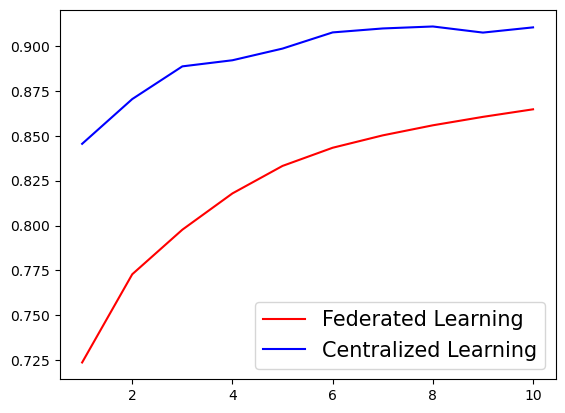

In [13]:
x_axis = list(range(1, num_round+1))
plt.plot(x_axis, acc_list,'r',label="Federated Learning")
plt.plot(x_axis, acc_list2,'b',label="Centralized Learning")
plt.legend(fontsize=15)
plt.show()

# Conclusion
```
Eventhough, the performance is not as good as the centeralized learning, the model can learn.
The final goal of Federated Learning is to make model learning like models which are in the centeralized environments.
```